<a href="https://colab.research.google.com/github/Bejofo/PolyNoteDetection/blob/main/PolyNote4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#What is version control
#@title Install Dependeices
# nasty dependeices
!apt-get update -qq && apt-get install -qq libfluidsynth1 fluid-soundfont-gm build-essential libasound2-dev libjack-dev
!pip install -qU pyfluidsynth pretty_midi librosa
# import ctypes.util
# orig_ctypes_util_find_library = ctypes.util.find_library
# def proxy_find_library(lib):
#   if lib == 'fluidsynth':
#     return 'libfluidsynth.so.1'
#   else:
#     return orig_ctypes_util_find_library(lib)
# ctypes.util.find_library = proxy_find_library

Selecting previously unselected package fluid-soundfont-gm.
(Reading database ... 160706 files and directories currently installed.)
Preparing to unpack .../fluid-soundfont-gm_3.1-5.1_all.deb ...
Unpacking fluid-soundfont-gm (3.1-5.1) ...
Selecting previously unselected package libfluidsynth1:amd64.
Preparing to unpack .../libfluidsynth1_1.1.9-1_amd64.deb ...
Unpacking libfluidsynth1:amd64 (1.1.9-1) ...
Setting up fluid-soundfont-gm (3.1-5.1) ...
Setting up libfluidsynth1:amd64 (1.1.9-1) ...
Processing triggers for libc-bin (2.27-3ubuntu1.2) ...
/sbin/ldconfig.real: /usr/local/lib/python3.7/dist-packages/ideep4py/lib/libmkldnn.so.0 is not a symbolic link

     |████████████████████████████████| 5.6MB 6.2MB/s 
     |████████████████████████████████| 51kB 5.3MB/s 


In [ ]:
!gdown https://drive.google.com/u/1/uc?id=1veeiwPPhMC1zIEcTnpQGXWRVyNTaMeyO -O MidiData.zip
!unzip /content/MidiData.zip 

In [2]:
import code
import librosa
import pretty_midi
import numpy as np
import matplotlib.pyplot as plt
# from PIL import Image

def gen_wav_file(filename):
  midi_data = pretty_midi.PrettyMIDI(filename)
  res = 22016//512
  roll = midi_data.get_piano_roll(fs=res)[21:109, :int(60*res)] # extract just the 88 notes needed
  trimed_midi = piano_roll_to_pretty_midi(roll)
  wav_data = trimed_midi.fluidsynth(fs=22016)[:int(22016*60)]
  import soundfile as sf
  sf.write("test.wav",wav_data,22016)

def piano_roll_to_pretty_midi(piano_roll, fs=43, program=0):
    '''Convert a Piano Roll array into a PrettyMidi object
     with a single instrument.
    Parameters
    ----------
    piano_roll : np.ndarray, shape=(128,frames), dtype=int
        Piano roll of one instrument
    fs : int
        Sampling frequency of the columns, i.e. each column is spaced apart
        by ``1./fs`` seconds.
    program : int
        The program number of the instrument.
    Returns
    -------
    midi_object : pretty_midi.PrettyMIDI
        A pretty_midi.PrettyMIDI class instance describing
        the piano roll.
    '''
    notes, frames = piano_roll.shape
    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(program=program)

    # pad 1 column of zeros so we can acknowledge inital and ending events
    piano_roll = np.pad(piano_roll, [(0, 0), (1, 1)], 'constant')

    # use changes in velocities to find note on / note off events
    velocity_changes = np.nonzero(np.diff(piano_roll).T)

    # keep track on velocities and note on times
    prev_velocities = np.zeros(notes, dtype=int)
    note_on_time = np.zeros(notes)

    for time, note in zip(*velocity_changes):
        # use time + 1 because of padding above
        velocity = piano_roll[note, time + 1]
        time = time / fs
        if velocity > 0:
            if prev_velocities[note] == 0:
                note_on_time[note] = time
                prev_velocities[note] = velocity
        else:
            pm_note = pretty_midi.Note(
                velocity=prev_velocities[note],
                pitch=note,
                start=note_on_time[note],
                end=time)
            instrument.notes.append(pm_note)
            prev_velocities[note] = 0
    pm.instruments.append(instrument)
    return pm

def genFeatures(filename,endTime):
    print(f"Processsing {filename}")
    midi_data = pretty_midi.PrettyMIDI(filename)
    res = 22016//512
    roll = midi_data.get_piano_roll(fs=res)[21:109, :int(endTime*res)] # extract just the 88 notes needed
    trimed_midi = piano_roll_to_pretty_midi(roll)
    wav_data = trimed_midi.fluidsynth(fs=22016)[:int(22016*endTime)]
    cqt = librosa.cqt(wav_data,
                      sr=22016,
                      hop_length=512, # must be a power of two
                      n_bins=88,
                      bins_per_octave=12,
                      fmin=librosa.note_to_hz('A0')) #lowest piano note
    return np.fmin(roll.T, 1), abs(cqt.T)[:-res-1] 
    # because of padding, we need to chop off the end 
    # to ge the same size

import os
dir = "/content/midiDataSet/archive/2011/midi/"
files = [f"{dir}{file}" for file in os.listdir(dir) if file.endswith(".MID") or  file.endswith(".midi")]
dir = "/content/midiDataSet/archive/2009/midi/"
files += [f"{dir}{file}" for file in os.listdir(dir) if file.endswith(".MID") or  file.endswith(".midi")]
gen_wav_file(files[0])
N = 1
inputData = np.zeros((N,43*60,88,1))
outputData = np.zeros((N,43*60,88,1))
# print(files)
for i,file in enumerate(files[:N]):
    print(i)
    roll,cqt = genFeatures(file,60)
    roll = roll.reshape((*roll.shape,1))
    cqt = cqt.reshape((*cqt.shape,1))
    inputData[i,:cqt.shape[0]] = cqt
    outputData[i,:roll.shape[0]] = roll


FileNotFoundError: ignored

In [3]:
import matplotlib.pyplot as plt
# np.savez_compressed('/content/polynote4data', i=inputData, o=outputData.astype('uint8'))
plt.rcParams['figure.figsize'] = [18,8]
plt.imshow(outputData[0].reshape(43*60,88).T,aspect='auto',cmap='binary')
inputData.shape
# plt.imshow(inputData[1].reshape(43*60,88).T,aspect='auto',cmap='binary')
# np.min(inputData[1])
# np.average(outputData[0].reshape(43*60,88).T)

NameError: ignored

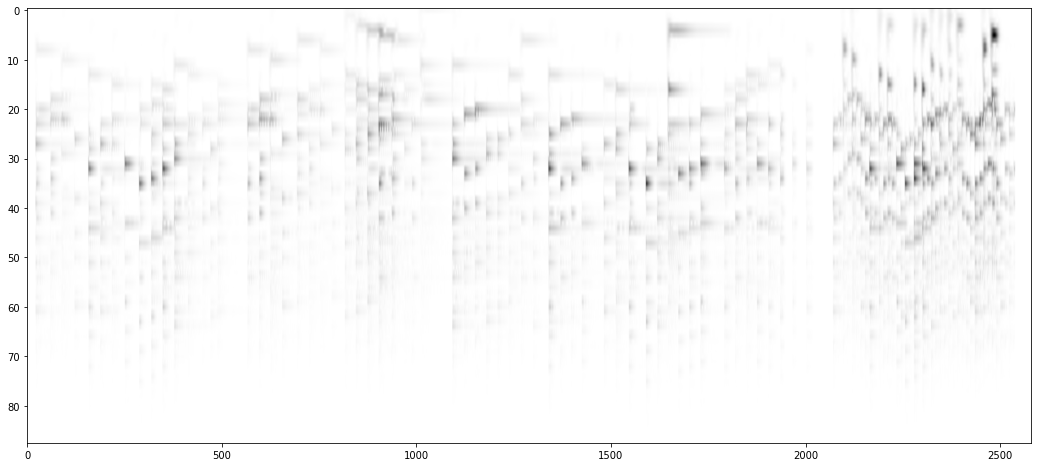

In [ ]:
plt.imshow(inputData[1].reshape(43*60,88).T,aspect='auto',cmap='binary')

In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense,InputLayer, UpSampling2D
from keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D
from keras.layers.normalization import BatchNormalization
from keras import backend as K 
K.clear_session() 

model = Sequential()
model.add(InputLayer(input_shape=(None, 88, 1)))
model.add(Conv2D(4, (20, 1), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(88, (1, 88), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(1, (1, 1), activation='sigmoid', padding='same'))
model.build()
model.summary()

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

def z_score(ar):
  return ar 
  # return (ar-np.mean(ar))/np.std(ar)

model.fit(inputData,outputData,epochs=70,validation_split=0.2)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, None, 88, 4)       84        
_________________________________________________________________
batch_normalization (BatchNo (None, None, 88, 4)       16        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, 88, 88)      31064     
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 88, 88)      352       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, 88, 1)       89        
Total params: 31,605
Trainable params: 31,421
Non-trainable params: 184
_________________________________________________________________
Epoch 1/70


In [ ]:
model.fit(z_score(inputData),outputData,epochs=40,validation_split=0.2)

In [ ]:
pred = model.predict(z_score(inputData))[1]
# t = 0.05
# pred[pred > t] = 1  
# pred[pred <= t] = 0  
# # #pred = 1-np.ceil(pred)
# print(pred.shape)
matrix = pred.reshape(pred.shape[:2]).T
# for freq in matrix:
#   for i in range(freq.shape[0]):
#     if freq[i] == 0:
#       pass
#     j = i 
#     while freq[j] == 1:
#       j+=1
#     if j-i < 10: # shortest run 
#       freq[i:j] = 0
#     i = j
plt.imshow(matrix,aspect='auto',cmap='binary')


NameError: ignored

In [4]:
# model.save('somewhatuseful')
# !zip -r r.zip somewhatuseful
!unzip r.zip

Archive:  r.zip
   creating: somewhatuseful/
  inflating: somewhatuseful/saved_model.pb  
   creating: somewhatuseful/variables/
  inflating: somewhatuseful/variables/variables.data-00000-of-00001  
  inflating: somewhatuseful/variables/variables.index  
   creating: somewhatuseful/assets/


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


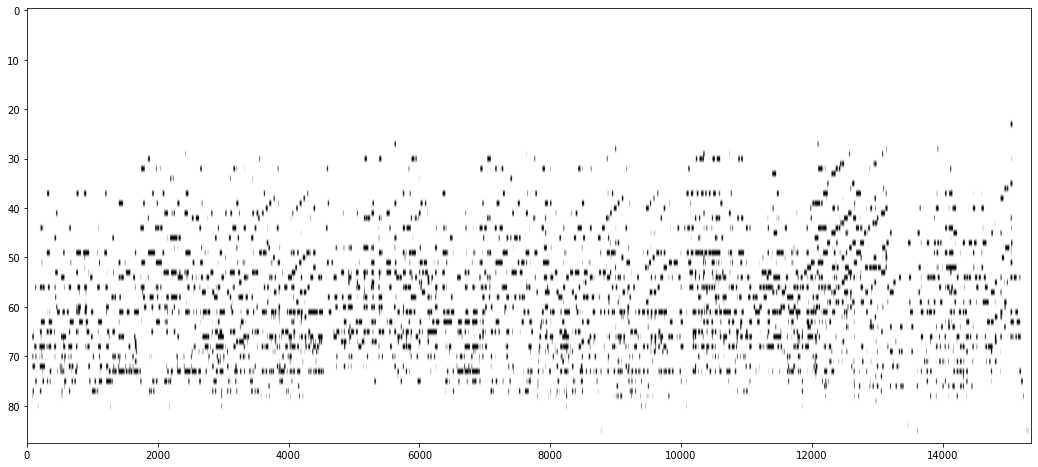

In [11]:
def wav2midi(filename,modelname):
  if type(modelname) is str:
    model = keras.models.load_model(modelname)
  else:
    model = modelname
  audio_data,_ = librosa.load(filename, sr=22016)
  res = 22016//512
  cqt = librosa.cqt(audio_data,
                    sr=22016,
                    hop_length=512, # must be a power of two
                    n_bins=88,
                    bins_per_octave=12,
                    fmin=librosa.note_to_hz('A0')) #lowest piano note
  cqt = abs(cqt.T)[:-res-1] 
  cqt = np.array([cqt.reshape((*cqt.shape,1))])
  pred = model.predict(cqt)[0]
  pred = pred.reshape(pred.shape[:2])
  t = 0.06
  pred[pred > t] = 1  
  pred[pred <= t] = 0  
  # print(pred.shape)
  matrix = pred.T
  for freq in matrix:
    i = 0
    while i < freq.shape[0]:
      if freq[i] == 1:
        i+=1
        continue
      j = i 
      while j < len(freq) and freq[j] == 0:
        j+=1
      if j-i < 2:
        freq[i:j] = 1
      i = j
  for freq in matrix:
    i = 0
    while i < freq.shape[0]:
      if freq[i] == 0:
        i+=1
        continue
      j = i 
      while j < len(freq) and freq[j] == 1:
        j+=1
      if j-i < 2:
        freq[i:j] = 0
      i = j
  mid = piano_roll_to_pretty_midi(matrix*20)
  plt.imshow(matrix,aspect='auto',cmap='binary')
  return mid
  

import code
import librosa
import pretty_midi
import numpy as np
import keras

# !unzip r.zip
a = wav2midi("/content/Spirited Away - Inochi no Namae (The Name of Life) いのちの名前-0WWfz-5ivmE.mid.mp3","/content/somewhatuseful")

In [12]:
a.write('life.mid')

NameError: ignored